In [3]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"Is CUDA available? {cuda_available}")

if cuda_available:
    # Get the name of the GPU device
    gpu_name = torch.cuda.get_device_name(0)
    # Get the current GPU device index
    gpu_index = torch.cuda.current_device()
    print(f"CUDA Device index: {gpu_index}")
    print(f"CUDA Device name: {gpu_name}")
else:
    print("CUDA is not available, PyTorch will use the CPU.")


Is CUDA available? True
CUDA Device index: 0
CUDA Device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [6]:
import numpy as np
X = [0,1]
w1 = [2,3]
w2 = [0.4,1.8]
# which weight is more similar to X?
d1 = X[0] * w1[0] + X[1] * w1[1]
d1
d2 = X[0] * w2[0] + X[1] * w2[1]
d2

print(np.dot(X , w1))
print(np.dot(X , w2))


3
1.8


# Dataset study

array([[22,  8],
       [13, 18]])

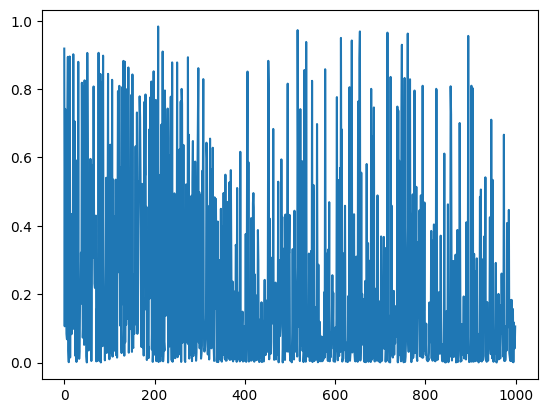

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

df = pd.read_csv("heart.csv")
df.head()

X = df.drop("output", axis=1)
y = df["output"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#%% scale the data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

class NNS:
    def __init__(self,LR,X_train,y_train,X_test,y_test):
        self.w = np.random.rand(X_train.shape[1])
        self.b = np.random.rand()
        self.LR = LR
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.L_train = []
        self.L_test = []

    def activation(self,x):
        return 1/(1+np.exp(-x))
        
    def deactivation(self,x):
        return self.activation(x) * (1 - self.activation(x))

    def forward(self,X):
        hidden_1 = np.dot(X , self.w) + self.b
        activate_1 = self.activation(hidden_1)
        return activate_1
    
    def backward(self, X, y_true):
        hidden_1 = np.dot(X , self.w) + self.b
        y_pred = self.forward(X)
        dl_dpred = 2 * (y_pred - y_true)
        dpred_dhidden1 = self.deactivation(hidden_1)
        dhidden1_db = 1
        dhidden1_dw = X

        dl_db = dl_dpred * dpred_dhidden1 * dhidden1_db
        dl_dw = dl_dpred * dpred_dhidden1 * dhidden1_dw
        return dl_dw, dl_db
    
    def optimizer(self, dl_db, dl_dw):
        self.b = self.b - dl_db * self.LR
        self.w = self.w - dl_dw * self.LR

    def train(self,epochs):
        for i in range(epochs):
            #randomly
            random_pos = np.random.randint(len(self.X_train))

            #forward
            y_train_true = self.y_train[random_pos]
            y_train_pred = self.forward(self.X_train[random_pos])

            #cal train
            L = np.sum(np.square(y_train_pred - y_train_true))
            self.L_train.append(L)

            #cal gradient
            dl_dw, dl_db = self.backward(self.X_train[random_pos], self.y_train[random_pos])
            #update weights
            self.optimizer(dl_db, dl_dw)

            #cal error on each epochs
            L_sum = 0
            for j in range(len(self.X_test)):
                y_test_true = self.y_test[j]
                y_test_pred = self.forward(self.X_test[j])
                L_sum += np.sum(np.square(y_test_pred - y_test_true))
            self.L_test.append(L_sum)

        return "training finished "
    
LR = 0.01
epochs = 1000

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

nn = NNS(LR = LR,X_train = X_train_scale,y_train = y_train,X_test = X_test_scale,y_test = y_test)
nn.train(epochs = epochs)

sns.lineplot(x = list(range(len(nn.L_train))), y = nn.L_train)

total = X_test_scale.shape[0]
correct = 0
y_preds = []

for i in range(total):
    y_true = y_test[i]
    y_pred = np.round(nn.forward(X_test_scale[i]))
    y_preds.append(y_pred)
    correct += 1 if y_true == y_pred else 0

#accuracy
acc = correct/total

from collections import Counter

Counter(y_test)
confusion_matrix(y_true = y_test,y_pred = y_preds)


      

2025-11-09 11:44:54.485121: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 11:44:58.726081: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-09 11:47:05.101922: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mnt/c/ubuntu/ml/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarnin

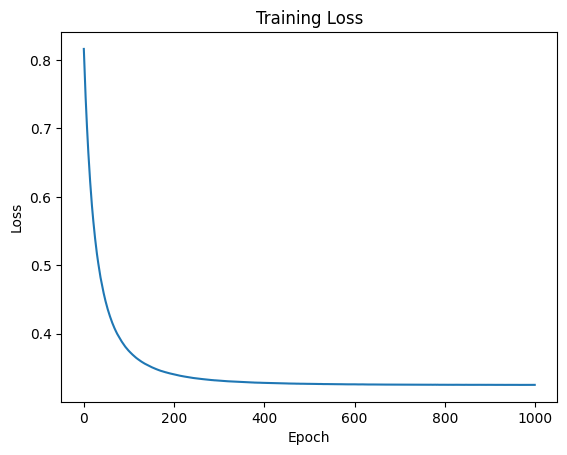

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Test Accuracy: 0.7541
Confusion Matrix:
[[22  8]
 [ 7 24]]


In [6]:
# tensorflow

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load data
df = pd.read_csv("heart.csv")
X = df.drop("output", axis=1)
y = df["output"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build model: Single layer neural network with sigmoid activation
model = Sequential([
    Dense(1, input_shape=(X_train_scaled.shape[1],), activation='sigmoid')
])

# Compile model with binary cross-entropy loss and optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train_scaled, y_train, epochs=1000, verbose=0, validation_data=(X_test_scaled, y_test))

# Plot training loss curve
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Evaluate on test set
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = np.round(y_pred_prob)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
